# credit card transaction fraud

# loading data

In [1]:
import pandas as pd
import os

training_data_path = "fraudTrain.csv"
test_data_path = "fraudTest.csv"

training_data_raw = pd.read_csv(training_data_path)
test_data_raw = pd.read_csv(test_data_path)

# cleaning data

In [2]:
#data cleaning here
training_data_clean = {"cc_num": [], "merchant": [], "category": [], "amt": [], "first": [], "last": [], "gender": [], "lat": [], "long": [], "city_pop": [], "job": [], "unix_time": [], "merch_lat": [], "merch_long": [], "is_fraud": []}
for idx in range(len(training_data_raw["cc_num"])):
    for key in training_data_clean.keys():
        training_data_clean[key].append(training_data_raw[key][idx])
training_data_clean = pd.DataFrame.from_dict(training_data_clean)
training_data_clean.to_csv("credit_card_fraud_clean_train.csv", index=False)

test_data_clean = {"cc_num": [], "merchant": [], "category": [], "amt": [], "first": [], "last": [], "gender": [], "lat": [], "long": [], "city_pop": [], "job": [], "unix_time": [], "merch_lat": [], "merch_long": [], "is_fraud": []}
for idx in range(len(test_data_raw["cc_num"])):
    for key in test_data_clean.keys():
        test_data_clean[key].append(test_data_raw[key][idx])
test_data_clean = pd.DataFrame.from_dict(test_data_clean)
test_data_clean.to_csv("credit_card_fraud_clean_test.csv", index=False)

In [3]:
training_data_clean

,cc_num,merchant,category,amt,first,last,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",1325376018,36.011293,-82.048315,0
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,1325376044,49.159047,-118.186462,0
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,42.1808,-112.2620,4154,Nature conservation officer,1325376051,43.150704,-112.154481,0
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,46.2306,-112.1138,1939,Patent attorney,1325376076,47.034331,-112.561071,0
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,38.4207,-79.4629,99,Dance movement psychotherapist,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,37.7175,-112.4777,258,Geoscientist,1371816728,36.841266,-111.690765,0
1296671,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,39.2667,-77.5101,100,"Production assistant, television",1371816739,38.906881,-78.246528,0
1296672,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,32.9396,-105.8189,899,Naval architect,1371816752,33.619513,-105.130529,0
1296673,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,43.3526,-102.5411,1126,Volunteer coordinator,1371816816,42.788940,-103.241160,0


In [4]:
fraud_data = training_data_clean.loc[training_data_clean['is_fraud'] == 1]
fraud_data = fraud_data[['cc_num', 'merchant', 'category', 'job']]

In [5]:
fraud_data

,cc_num,merchant,category,job
2449,4613314721966,fraud_Rutherford-Mertz,grocery_pos,Soil scientist
2472,340187018810220,"fraud_Jenkins, Hauck and Friesen",gas_transport,Horticultural consultant
2523,340187018810220,fraud_Goodwin-Nitzsche,grocery_pos,Horticultural consultant
2546,4613314721966,fraud_Erdman-Kertzmann,gas_transport,Soil scientist
2553,340187018810220,fraud_Koepp-Parker,grocery_pos,Horticultural consultant
...,...,...,...,...
1295399,3524574586339330,fraud_Kassulke PLC,shopping_net,"Librarian, public"
1295491,3524574586339330,fraud_Schumm PLC,shopping_net,"Librarian, public"
1295532,4005676619255478,"fraud_Tillman, Dickinson and Labadie",gas_transport,Herbalist
1295666,3560725013359375,fraud_Corwin-Collins,gas_transport,Cytogeneticist


In [6]:
from itertools import combinations

def apriori(dataset, minSup):
  print("Minimum Support: ", minSup)
  # first pass
  L = first_pass(dataset)
  # Create 1-itemset candidates
  F = {1: L[L['count'] / len(dataset) >= minSup]}
  F[1] = F[1].reset_index(drop=True)
  #print(F[1])
  print("1-item set: ", len(F[1]))
  # second pass of Apriori: count only frequent pairs
  k = 2
  while len(F[k - 1]) != 0:
    # create candidate itemset
    L = apriori_gen(F, k - 1)
    L[k]['count'] = 0
    for i in range(len(dataset)):
      for j in range(len(L[k])):
        # check if the set can be found in the dataset
        if set(L[k]['category'][j]).issubset(dataset[i]):
          L[k].loc[j, 'count'] += 1
    
    # finally define them as frequent itemsets
    F[k] = L[k][L[k]['count'] / len(dataset) >= minSup]
    F[k] = F[k].reset_index(drop=True)

    print(str(k) + "-item set: " + str(len(F[k])))
    if k == 2:
      break
  
  return F

# first pass of Apriori: count all items
def first_pass(dataset):
  counts = pd.DataFrame(columns=['category', 'count'])

  for i in range(len(dataset)):
    for j in range(len(dataset[i])):
      # if the movie id is already in counts, increment counts
      if dataset[i][j] in counts.values:
        ind = counts[counts['category']==dataset[i][j]].index.values
        counts.loc[ind, 'count'] += 1
      # if the movie id is not yet registered in counts
      else:
        #print(dataset[i][j])
        counts.loc[len(counts.index)] = [dataset[i][j], 1]

  counts = counts.reset_index(drop=True)
  #print(counts.values)
  return counts         

# generate candidate frequent k-itemset
def apriori_gen(L, k):
  result = {k + 1: pd.DataFrame(columns=['category'])}
  c = []
  # create combinations of k items 
  c = list(combinations(L[1]['category'], k + 1))
  # add this combinations to the candidate set
  for i in range(len(c)):
    result[k + 1].loc[i] = [c[i]]

  #print(result)
  return result        

In [7]:
fraud_data_mct = fraud_data.sort_values('merchant')
tm = fraud_data_mct.groupby(['merchant'])['category'].apply(list).values.tolist()

In [8]:
fraud_data_ccn = fraud_data.sort_values('cc_num')
tc = fraud_data_ccn.groupby(['cc_num'])['merchant'].apply(list).values.tolist()

In [9]:
fraud_data.drop_duplicates(subset=['category'])

,cc_num,merchant,category,job
2449,4613314721966,fraud_Rutherford-Mertz,grocery_pos,Soil scientist
2472,340187018810220,"fraud_Jenkins, Hauck and Friesen",gas_transport,Horticultural consultant
2937,4613314721966,fraud_Medhurst PLC,shopping_net,Soil scientist
3527,4613314721966,fraud_Ruecker Group,misc_net,Soil scientist
4383,4922710831011201,fraud_Pouros-Conroy,shopping_pos,Public affairs consultant
4693,4922710831011201,fraud_Mosciski Group,travel,Public affairs consultant
4808,341546199006537,"fraud_Stokes, Christiansen and Sipes",grocery_net,"Administrator, education"
6141,341546199006537,fraud_Wisozk and Sons,misc_pos,"Administrator, education"
6240,341546199006537,fraud_Friesen Ltd,health_fitness,"Administrator, education"
7529,341546199006537,"fraud_Hauck, Dietrich and Funk",kids_pets,"Administrator, education"


In [47]:
def associate_rules(T, F, minConf):
  k = 2
  consq = []
  rules = pd.DataFrame(columns=['X_Job', 'Y_Job', 'Sup', 'Conf'])
  #print(F[k])
  while len(F[k]) != 0:
    #print("leggo")
    for i in range(len(F[k])):
      # create candidate rules
      consq = list(combinations(F[k]['category'][i], 1))
      #print("F[k]['count'][i]", F[k]['count'][i])
      #print(len(consq))
      #print(consq)
      # filter cnadidate rules with minimum confidence
      for c in consq:
        x = list(set(F[k]['category'][i])-set(c))
        x_size = len(x)
        x_count = 0
        for j in range(len(F[x_size])):
          #print(type(F[x_size]['movieId'][j]))
          if x_size == 1 and F[len(x)]['category'][j] == x[0]:
            x_count = F[x_size]['count'][j]
            continue
          if x_size > 1:
            if len(list(set(F[x_size]['category'][j]) - set(x))) == 0:
              x_count = F[x_size]['count'][j]
        #print(c)
        # print("x: ", x)
        # print("x_count: ", x_count)

        # add rules that has confidence greater than or equal to the minimum confidence
        if (F[k]['count'][i] / x_count) >= minConf:
          rules.loc[len(rules.index)] = [list(x), list(set(F[k]['category'][i]) - set(x)), F[k]['count'][i] / len(T), F[k]['count'][i] / x_count]

    if k == 2:
      break

  return rules


In [48]:
fraud_data.category.unique()
#print(rules)

#print(combinations(frequent[1]['nameDest'][1], 1))
# rules = associate_rules(tm, frequent, 0)

array(['grocery_pos', 'gas_transport', 'shopping_net', 'misc_net',
       'shopping_pos', 'travel', 'grocery_net', 'misc_pos',
       'health_fitness', 'kids_pets', 'entertainment', 'food_dining',
       'home', 'personal_care'], dtype=object)

In [12]:
fraud_data_ctg = fraud_data.sort_values('merchant')
tcg = fraud_data_ctg.groupby(['merchant'])['job'].apply(list).values.tolist()

In [13]:
# for category in tcg:
#   #print(category)
#   category = list(set(category))
#   #print("new", category)

In [15]:
frequent = apriori(tcg, 0.015)

Minimum Support:  0.015
1-item set:  298
2-item set: 5


In [49]:
rules = associate_rules(tcg, frequent, 0.25)

In [50]:
rules

,X_Job,Y_Job,Sup,Conf
0,[Systems analyst],"[Surveyor, land/geomatics]",0.016200,0.323529
1,[Audiological scientist],[Naval architect],0.017673,0.260870
2,[Film/video editor],[Audiological scientist],0.019146,0.295455
3,[Audiological scientist],[Film/video editor],0.019146,0.282609
4,[Film/video editor],[Trading standards officer],0.017673,0.272727


In [82]:
#frequent

In [124]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

B = nx.Graph()
B.add_nodes_from(['Systems analyst', 'Audiological scientist', 'Film/video editor'], bipartite=1)
B.add_nodes_from(['Surveyor, land/geomatics', 'Naval architect',  'Audiological scientist', 'Trading standards officer', 'Film/video editor'], bipartite=1)
B.add_edges_from([('Systems analyst', 'Surveyor, land/geomatics'), ('Audiological scientist', 'Naval architect'), ('Audiological scientist', 'Film/video editor'), ('Film/video editor', 'Audiological scientist'), ('Film/video editor', 'Trading standards officer')])

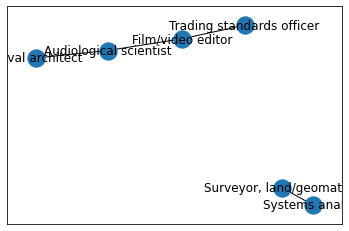

In [128]:
nx.draw_networkx(B, with_labels=True)